In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from src.common.analysis_and_plots import Visualize as V
from src.features.build_features import FeatureEngineering as FE
from src.common.globals import G
from src.common.globals import split_train_valid_test, get_naive_forecast, calc_errors, save_errors_to_table
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info

import logging
import os
from datetime import datetime

logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

PROJECT_PATH = G.get_project_root()
DATA_DIR_PROCESSED = os.path.join(PROJECT_PATH, r'data\03_processed\daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': 20,
        'batch_size' : 32,
        'shuffle_buffer_size' : 5600, # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
        'epochs' : 100,
        'optimizer': tf.keras.optimizers.Adam(),
        'loss': tf.keras.losses.Huber(),
    },
}

In [ ]:
def label_column_to_end(df, last_column):
    ''' 
    Changes positions of columns in df to put the target column at the end

    Args:
        df (pandas dataframe) - dataframe to change
        last_column (string) - name of the column to put at the end
        
    Returns:
        df (pandas dataframe) - dataframe with the target column at the end
    '''
    cols = df.columns.tolist()
    cols.remove(last_column)
    cols.append(last_column)
    return df[cols]

In [31]:
def windowed_dataset_X(df, window_size, batch_size, shuffle_buffer, verbose=True):
    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')

    X_df = df.iloc[:, :-1]
    y_df = df.iloc[:, -1:]

    scalers = {}
    for col in X_df.columns:
        scaler = MinMaxScaler()
        X_df[col] = scaler.fit_transform(X_df[col].values.reshape(-1,1))
        scalers[col] = scaler
    
    # Creating X and y
    X = X_df.values
    y = y_df.values
    if verbose:
        print('---------------------------------X,y shape-------------------------------------')
        print (f'X.shape: {X.shape}, y.shape: {y.shape}')
        print('-'*100)


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(X)
    if verbose:
        print('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            print(element)
            break
        print('-'*100)

    # Window the data but only take those with the specified size
    # And add + 1 to the window size to account for the label, which we will separate later
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    if verbose:
        print('-------------------------------window-----------------------------------')
        for window in dataset:
            print(type(window))
            print(list(window.as_numpy_iterator()))
            break
        print('-'*100)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    if verbose:
        print('--------------------------------flat_map--------------------------------')
        for window in dataset:
            print(window)
            break
        print('-'*100)

    return dataset, scalers

# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)

test_size_int = int(len(df) * config['data']['test_size'])
df_train = df.iloc[:-test_size_int].copy(deep=True)
df_test = df.iloc[-test_size_int:].copy(deep=True)

for col in df.columns:
    df_train[f'{col} - 1'] = df_train[col].shift(1)
    df_test[f'{col} - 1'] = df_test[col].shift(1)
df_train = df_train.dropna()
df_test = df_test.dropna()

#Drop Original columns is any left 
df_train = df_train.drop(columns=['Volume'])

2023-09-20 16:16:18 - src.data.get_data - INFO - Loaded "..\P7-Trading-Bot\data\03_processed\daily_full\MSFT-daily-full.csv". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"


In [ ]:
def windowed_dataset_y(df, window_size, batch_size, shuffle_buffer, verbose=True):
    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')

    # Creating X and y
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1:].values
    if verbose:
        print('---------------------------------X,y shape-------------------------------------')
        print (f'X.shape: {X.shape}, y.shape: {y.shape}')
        print('-'*100)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(y)
    if verbose:
        print('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            print(element)
            break
        print('-'*100)

    # calculate number of points we need to cut to make series evenly divisible by window_size
    remainder = window_size - 1

    # Remove the reminder elements from the end of dataset
    dataset = dataset.take(len(y) - remainder)
    if verbose:
        print('--------------------------------take len(y)-reminder--------------------------------')
        for window in dataset:
            print(window)
            break
        print('-'*100)
    
    return dataset

In [ ]:
train_dataset_X, scalers_X = windowed_dataset_X(df_train, 
                                                window_size=config['model']['window'], 
                                                batch_size=config['model']['batch_size'], 
                                                shuffle_buffer=config['model']['shuffle_buffer_size'],
                                                verbose=True)
print('Lenght of X =', len(list(train_dataset_X.as_numpy_iterator())))

In [ ]:
train_dataset_y = windowed_dataset_y(df_train, 
                                     window_size=config['model']['window'], 
                                     batch_size=config['model']['batch_size'], 
                                     shuffle_buffer=config['model']['shuffle_buffer_size'], 
                                     verbose=True)
print('Lenght of y =', len(list(train_dataset_y.as_numpy_iterator())))

In [ ]:
train_dataset = tf.data.Dataset.zip((train_dataset_X, train_dataset_y))
train_dataset = train_dataset.shuffle(config['model']['shuffle_buffer_size'])
train_dataset = train_dataset.batch(config['model']['batch_size']).prefetch(1)

for x, y in train_dataset:
    print (f'x.shape: {x.numpy().shape}, y.shape: {y.numpy().shape}')
    break

In [ ]:
input_shape = train_dataset.element_spec[0].shape
print(f'Input shape: {input_shape}')

In [ ]:
# -----------------------------Model Architecture--------------------------
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None,2)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
        ],
    name=config['model']['name'])

model._name = f"{model._name}_{str(model.count_params())}_{datetime.now().strftime('%Y-%m-%d--%H-%M')}"
log_model_info(config, model, logger)

In [ ]:
# Set the training parameters and train the model
model.compile(loss=config['model']['loss'], 
            optimizer=config['model']['optimizer'], 
            metrics=["mae"],
            )    

# Train the model
history = model.fit(train_dataset, epochs=config['model']['epochs'])

# Plot MAE and Loss
mae=history.history['mae']
loss=history.history['loss']
zoom = int(len(mae) * 0.9)
V.plot_series(x=range(config['model']['epochs'])[-zoom:],
                y=(mae[-zoom:],loss[-zoom:]),
                model_name=config['model']['name'],
                title='MAE_and_Loss',
                xlabel='MAE',
                ylabel='Loss',
                legend=['MAE', 'Loss']
            )

# Save the model
FE.model_save(model, logger)

In [109]:
def model_forecast(model, df, scalers:dict, verbose=False):
    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')
    if verbose:
        print('---------------------------------df shape-------------------------------------')
        print (f'df.shape: {df.shape}')
        print(df.iloc[:2])
        print('-'*100)

    X_df = df.iloc[:, :-1].copy(deep=True)
    if verbose:
        print('---------------------------------X_df shape-------------------------------------')
        print (f'X_df.shape: {X_df.shape}')
        print(X_df.iloc[:2])
        print('-'*100)

    # Scale the data
    for col in X_df.columns:
        scaler = scalers[col]
        X_df[col] = scaler.transform(X_df[col].values.reshape(-1,1))

    X = X_df.values
    if verbose:
        print('---------------------------------X shape, X-------------------------------------')
        print (f'X.shape: {X.shape}')
        print('First 2 values:', X[:2])
        print('-'*100)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(tf.constant(X))
    if verbose:
        print('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            print(element)
            break
        print('-'*100)

    # Expand dimension to match the model's input requirements
    dataset = dataset.batch(config['model']['batch_size'])
                                                                       
    if verbose:
        print('--------------------------------map + batch-----------------------------------')
        input_shape = dataset.element_spec.shape
        print(f'Input shape: {input_shape}')
        print('-'*100)


    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    print('--------------------------------forecast-----------------------------------')
    for i,x in enumerate(forecast):
        if i > 1:
            break
        print(i,x)
    print('-'*100)

    forecast = forecast.squeeze()


    return forecast

In [148]:
def model_forecast2(model, window_size, df, scalers:dict, verbose=False):
    # change the position of the target column to the end
    df = label_column_to_end(df, 'Adj Close')
    if verbose:
        print('---------------------------------df shape-------------------------------------')
        print (f'df.shape: {df.shape}')
        print(df.iloc[:2])
        print('-'*100)

    X_df = df.iloc[:, :-1].copy(deep=True)
    if verbose:
        print('---------------------------------X_df shape-------------------------------------')
        print (f'X_df.shape: {X_df.shape}')
        print(X_df.iloc[:2])
        print('-'*100)

    # Scale the data
    for col in X_df.columns:
        scaler = scalers[col]
        X_df[col] = scaler.transform(X_df[col].values.reshape(-1,1))
    
    # Creating X
    X = X_df.values
    if verbose:
        print('---------------------------------X shape-------------------------------------')
        print (f'X.shape: {X.shape}')
        print('-'*100)


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(X)
    if verbose:
        print('--------------------------from_tensor_slices--------------------------')
        for element in dataset:
            print(element)
            break
        print('-'*100)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    if verbose:
        print('-------------------------------window-----------------------------------')
        for window in dataset:
            print(type(window))
            print(list(window.as_numpy_iterator()))
            break
        print('-'*100)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    if verbose:
        print('--------------------------------flat_map--------------------------------')
        for window in dataset:
            print(window)
            break
        print('-'*100)

    # batch the data
    dataset = dataset.batch(1)
    if verbose:
        print('--------------------------------batch-----------------------------------')
        for batch in dataset:
            print(batch)
            break
        print('-'*100)
        
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    if verbose:
        print('--------------------------------forecast-----------------------------------')
        for i,x in enumerate(forecast):
            if i > 1:
                break
            print(i,x)
        print('-'*100)


    forecast = forecast.squeeze()

    return forecast

---------------------------------df shape-------------------------------------
df.shape: (298, 3)
            Adj Close - 1  Volume - 1   Adj Close
Date                                             
2022-06-23     250.175593  25961215.0  255.838716
2022-06-24     255.838716  25861449.0  264.575540
----------------------------------------------------------------------------------------------------
---------------------------------X_df shape-------------------------------------
X_df.shape: (298, 2)
            Adj Close - 1  Volume - 1
Date                                 
2022-06-23     250.175593  25961215.0
2022-06-24     255.838716  25861449.0
----------------------------------------------------------------------------------------------------
---------------------------------X shape-------------------------------------
X.shape: (298, 2)
----------------------------------------------------------------------------------------------------
--------------------------from_tensor_slices-----

ValueError: x and y must have same first dimension, but have shapes (298,) and (279,)

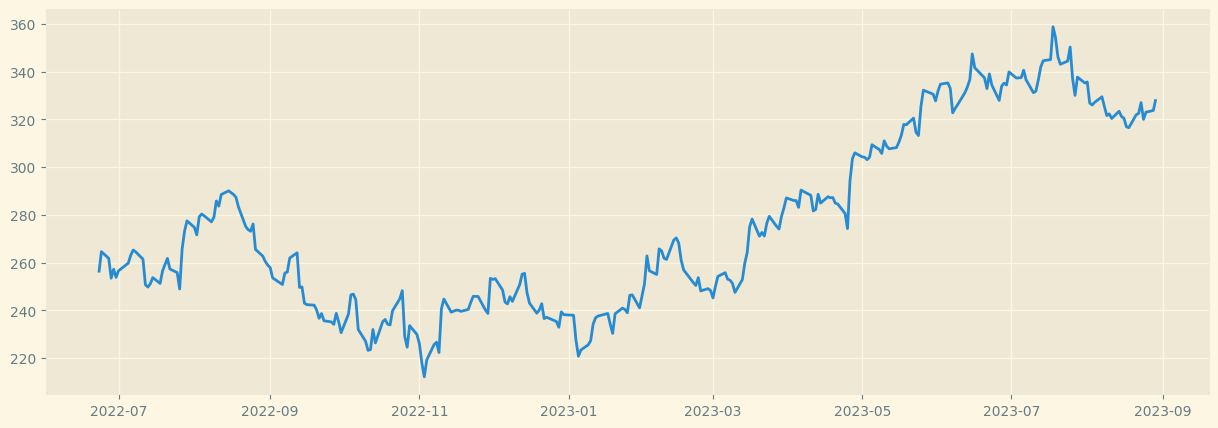

In [149]:
# Load model 
def model_load(model_name):
    model = tf.keras.models.load_model(os.path.join(PROJECT_PATH, rf'models_trained\{model_name}.keras'))
    return model
#--------------------------------------------------------------------------
model = model_load(model_name='LSTM_42113_2023-09-20--15-58')

# -----------------------------Predictions---------------------------------
forecast_df = df_test.copy(deep=True)
forecast_df = forecast_df.drop(columns=['Volume'])

results = model_forecast2(model=model, 
                        window_size=config['model']['window'],
                        df=forecast_df, 
                        scalers=scalers_X,
                        verbose=True)

print('Predicted shape:', results.shape)

V.plot_series(  x=df_test.index, 
                y=(df_test['Adj Close'], results),
                model_name=config['model']['name'])

In [ ]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = get_naive_forecast(df).iloc[-len(df_test['Adj Close']):]
rmse, mae, mape, mase = calc_errors(df_test['Adj Close'], results, naive_forecast)
save_errors_to_table(config['model']['name'], {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})